# Анализ пространственных данных. Домашнее задание №2

Мягкий дедлайн: __4 ноября 2020 г. 23:59__

Жесткий дедлайн (со штрафом в _50%_ от количества набранных вами за ДЗ баллов): __5 ноября 2020 г. 08:59__

Визуализация "чего-либо" __без__ выполненного основного задания оценивается в __0 баллов__

ФИО: `Богданов Максим Александрович`

Группа: `DS-11`

In [ ]:
!pip install geopandas
!pip install osmapi
!pip install OSMPythonTools
!pip install folium
!apt-get install -qq curl g++ make
!curl -L http://download.osgeo.org/libspatialindex/spatialindex-src-1.8.5.tar.gz | tar xz
import os
os.chdir('spatialindex-src-1.8.5')
!./configure
!make
!make install
!pip install rtree==0.8.3
!ldconfig
!pip install overpy
!pip install openrouteservice

In [ ]:
import json
import math
import random
import requests
import overpy
import folium
import pyproj
import geopandas as gpd
import numpy as np
from shapely import geometry
from shapely.geometry import Point, Polygon, LineString, MultiPolygon
from shapely.ops import linemerge, unary_union, polygonize
from rtree import index
from rtree.index import Rtree
import osmapi as osm
from OSMPythonTools.api import Api
from OSMPythonTools.overpass import overpassQueryBuilder, Overpass
from OSMPythonTools.nominatim import Nominatim

from openrouteservice import client

## Задание №1. Горячая точка (алгоритм - 10 баллов, визуализация - 10 баллов).

Генерируйте рандомные точки на планете Земля до тех пор, пока не попадете на территорию ``Афганистана``

1. Вы можете использовать функции принадлежности точки полигону и расстояния от точки до полигона (в метрах)
2. Предложите не наивный алгоритм поиска (генерировать __напрямую__ точку из полигона границ Афганистана __запрещено__)

In [ ]:
# Получаем полигон границ Афганистана
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
afghanistan = world[world['name'] == 'Afghanistan']
afghanistan_polygon = afghanistan.iloc[0]['geometry']

In [ ]:
# Функция для рассчета гаверсина, она нам понадобиться в течении всего HW2
def haversin_distance(origin, destination):
    lat1, lon1 = origin
    lat2, lon2 = destination
    RADIUS = 6371302.0

    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat / 2) * math.sin(dlat / 2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon / 2) * math.sin(dlon / 2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    d = RADIUS * c

    return d

In [ ]:
def naive_generate_random_point(polygon):
    """Первая - наивная функция генерирующая точки на планете земля, до тех пор
       пока не попадаем в границы полигона Афганистана""" 
    count = 0
    min_x, min_y, max_x, max_y = (-180, -90, 180, 90)
    while True:
        count += 1
        pnt_x = random.uniform(min_x, max_x)
        pnt_y = random.uniform(min_y, max_y)
        pnt = Point(pnt_x, pnt_y)
        if pnt.within(polygon):
            print("Количество итераций:", count)
            print(pnt)
            return pnt

Количество итераций: 4330
POINT (66.00009032762574 32.44796638828923)


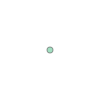

In [ ]:
naive_generate_random_point(afghanistan_polygon)

In [ ]:
def generate_random_point(polygon):
    """Вторая реализация, генерирует точки все ближе и ближе к Афганистану,
       считая расстояние от каждой до полигона Афганистана"""
    count = 0
    polygon_centroid_coords = list(polygon.centroid.coords)
    min_x, min_y, max_x, max_y = (-180.0, -90.0, 180.0, 90.0)
    m = folium.Map(location=[0.0, 0.0], zoom_start=2)
    tooltip = "Click"
    pnt_x = random.uniform(min_x, max_x)
    pnt_y = random.uniform(min_y, max_y)
    pnt = Point(pnt_x, pnt_y)
    while True:
        count += 1
        if pnt.within(polygon):
            print("Количество итераций:", count)
            print(pnt)
            return (pnt, m)
        else:
            pnt_coords = list(pnt.coords)
            distance_to_afghanistan = haversin_distance((pnt_coords[0][1], 
                                                         pnt_coords[0][0]),
                                                        (polygon_centroid_coords[0][1], 
                                                         polygon_centroid_coords[0][0]))
            pnt_new = 0
            while pnt != pnt_new:
                pnt_x_new = random.uniform(pnt_coords[0][0] - 1, pnt_coords[0][0] + 1)
                pnt_y_new = random.uniform(pnt_coords[0][1] - 1, pnt_coords[0][1] + 1)
                pnt_new = Point(pnt_x_new, pnt_y_new)
                pnt_new_coords = list(pnt_new.coords)
                if not pnt_new.within(polygon):
                    folium.Marker([pnt_y_new, pnt_x_new], 
                                  popup='<i>It is not Afghanistan</i>',
                                  tooltip=tooltip).add_to(m)
                else:
                    folium.Marker([pnt_y_new, pnt_x_new],
                                  popup='<i>Finally! It is Afghanistan!!!</i>',
                                  tooltip=tooltip).add_to(m)
                distance_to_afghanistan_new = haversin_distance((pnt_new_coords[0][1], 
                                                                 pnt_new_coords[0][0]),
                                                                (polygon_centroid_coords[0][1], 
                                                                 polygon_centroid_coords[0][0]))
                if distance_to_afghanistan_new < distance_to_afghanistan:
                    pnt = pnt_new

In [ ]:
found_point, m = generate_random_point(afghanistan_polygon)

Количество итераций: 129
POINT (70.92255705414428 34.81321679220083)


In [ ]:
m # Визуализация алгоритма

Визуализируйте пошагово предложенный алгоритм при помощи ``Folium``

## Задание №2. Качество жизни (20 баллов).

Для измерения показателя качества жизни в точке, найденной в предыдущем задании, вам необходимо рассчитать следующую сумму расстояний (в метрах):

1. Расстояние от точки до 5 ближайших __*__ банкоматов, находящихся в стране с наибольшим количеством объектов жилой недвижимости
2. Расстояние от точки до 5 ближайших школ, находящихся в стране с наибольшим количеством аптек в столице
3. Расстояние от точки до 5 ближайших кинотеатров, наодящихся в стране с самым большим отношением числа железнодорожных станций к автобусным остановкам в южной части __**__

__*__ При поиске _N_ ближайших объектов обязательно использовать ``R-tree``

__**__ Южной частью страны является территория, находящаяся к югу от множества точек, равноудаленных от самой северной и самой южной точек страны

In [ ]:
overpass = Overpass()
nominatim = Nominatim()

In [ ]:
# Поиск стран чей areaid оканчивается на 0
result = overpass.query("""
(
relation["type"="boundary"]["boundary"="administrative"]["admin_level"="2"];
);
out;
out count;
""")

area_ids = {}

for country in result.elements():
    if country.tag('name:en') is None:
        continue
    area_id = nominatim.query(country.tag('name:en')).areaId()
    if area_id is None:
        continue
    if (area_id % 10) == 0:
        area_ids[country.tag('name:en')] = area_id

In [ ]:
# Определяем страну с наибольшим количеством объектов жилой недвижимости
buildings = ['apartments', 'bungalow', 'cabin', 'detached', 'dormitory', 'farm', 
             'ger', 'hotel', 'house', 'houseboat', 'residential', 
             'semidetached_house', 'static_caravan', 'terrace']

dict_of_buildings = {}

for key in area_ids:
    areaID = area_ids[key]
    summ = 0

    for i in buildings:
        query = overpassQueryBuilder(area=areaID, 
                                     elementType=['way', 'relation'], 
                                     selector=f'"building"={i}', out='count')
        result = overpass.query(query, timeout=120)
        summ += result.countElements()
    dict_of_buildings[key] = summ
    
country_max = max(dict_of_buildings, key=dict_of_buildings.get)
print (f'Страна с наибольшим количеством объектов жилой недвижимости - {country_max}:', 
       dict_of_buildings[country_max])

In [ ]:
"""Получаем координаты всех ATM в Бразилии. Поскольку в предыдущем блоке мы уже
   выяснили, что искомая страна Бразилия, берем area_id напрямую, что бы при 
   повторном запуске ноутбука не перезапускать процедуру поиска страны с 
   наибольшим количеством объектов жилой недвижимости"""
Brazil_id = area_ids['Brazil']
api = overpy.Overpass()
query = overpassQueryBuilder(area=Brazil_id, elementType='node', 
                             selector='"amenity"="atm"', out='center')
atms = api.query(query)
coords  = []
coords += [(float(node.lon), float(node.lat)) 
           for node in atms.nodes]
idx = Rtree()
for i, p in enumerate(coords):
    idx.insert(i, p+p, p)
coords_of_afghanistan_point = list(found_point.coords)
nearest_atms = list(idx.nearest(coords_of_afghanistan_point[0], 5))
print('ОТВЕТ НА ЗАДАНИЕ 2.1:') 
print('Сумма расстояний до 5 ближаших банкоматов:')
counter = 0
for i in nearest_atms:
    counter += haversin_distance((coords_of_afghanistan_point[0][1], 
                                  coords_of_afghanistan_point[0][0]), 
                                 (coords[i][1], coords[i][0]))
print(round(counter, 2), 'метров')

ОТВЕТ НА ЗАДАНИЕ 2.1:
Сумма расстояний до 5 ближаших банкоматов:
57347434.3 метров


In [ ]:
# Поиск столиц
dict_of_capitals = {}
for key in area_ids:
    areaID = area_ids[key]
    query = overpassQueryBuilder(area=areaID, 
                                     elementType=['node', 'relation', 'way'], 
                                     selector='"capital"="yes"', out='meta')
    capital = overpass.query(query, timeout=120)
    if len(capital.elements()) > 0:
        dict_of_capitals[capital.elements()[0].tag('name:en')] = \
        nominatim.query(capital.elements()[0].tag('name:en')).areaId()
# В ручную заполняем id некоторых столиц
dict_of_capitals['Mbabane'] = 3601253019
dict_of_capitals['Canberra'] = 3602354197

In [ ]:
# Поиск столицы с наибольшим количеством аптек
dict_of_pharmacy = {}
for key in dict_of_capitals:
    areaID = dict_of_capitals[key]
    query = overpassQueryBuilder(area=areaID, 
                                 elementType=['node', 'way', 'relation'], 
                                 selector="'amenity'='pharmacy'", out='count')
    result = overpass.query(query, timeout=120)
    dict_of_pharmacy[key] = result.countElements()    
capital_max = max(dict_of_pharmacy, key=dict_of_pharmacy.get)
print (f'Столица с наибольшим количеством аптек - {capital_max}:', 
       dict_of_pharmacy[capital_max])

In [ ]:
"""Таким образом выясняется, что страна с наибольшим количеством аптек в столице
   это снова Бразилия"""
Brazil_id = area_ids['Brazil']
api = overpy.Overpass()
query = overpassQueryBuilder(area=Brazil_id, elementType=['node', 'way', 'relation'], 
                             selector='"amenity"="school"', out='center')
school = api.query(query)
coords_school  = []
coords_school += [(float(node.lon), float(node.lat)) 
                  for node in school.nodes]
idx2 = Rtree()
for i, p in enumerate(coords_school):
    idx2.insert(i, p+p, p)
coords_of_afghanistan_point = list(found_point.coords)
nearest_school = list(idx2.nearest(coords_of_afghanistan_point[0], 5))
print('ОТВЕТ НА ЗАДАНИЕ 2.2:') 
print('Сумма расстояние до 5 ближаших школ:')
counter = 0
for i in nearest_school:
    counter += haversin_distance((coords_of_afghanistan_point[0][1], 
                                  coords_of_afghanistan_point[0][0]), 
                                 (coords_school[i][1], coords_school[i][0]))
print (round(counter, 2), 'метров')

ОТВЕТ НА ЗАДАНИЕ 2.2:
Сумма расстояние до 5 ближаших школ:
59218123.26 метров


In [ ]:
# Функция поиска самой северной и самой южной точки страны
def find_out_north_and_south(id):
    country_bound = []
    ID = (id % 3600000000)
    api = overpy.Overpass()
    query = f"[out:json][timeout:25];rel({ID});out body;>;out skel qt;"
    result = api.query(query)
    for key, value in enumerate(result.ways):
        coords_counrty = []
        for node in value.nodes:
            coords_counrty.append((node.lon, node.lat))
        country_bound.append(geometry.LineString(coords_counrty))
    country = geometry.MultiPolygon(list(polygonize(unary_union(linemerge([*country_bound])))))
    for i in country:
        for j in list(i.exterior.coords):
            if j[1] == country.bounds[1]:
                south = j
            elif j[1] == country.bounds[3]:
                north = j
    return north, south

In [ ]:
# найдем север и юг каждой страны
norths = {}
souths = {}
for key in area_ids:
    areaID = area_ids[key]
    north, south = find_out_north_and_south(areaID)
    norths[key] = north
    souths[key] = south

**Павел, я сразу извинюсь, что Вам придется это увидеть, но если прогонять в цикле Overpass жалуется что запросов слишком много, поэтому, рассчет соотношения ж/д станций к автобусным остановкам будет призводиться в ручную для каждой страны. Далее следует несколько вызовов одной и той же функции для подсчета соотношений в каждой стране в каждом блоке будет меняться только страна**

In [ ]:
dict_of_ratio = {}

In [ ]:
# Функция подсчета соотношений ж/д станций к автобусным остановкам
def count_ratio(country):
    coords_railway  = []
    south_railway = []
    coords_bus  = []
    south_bus = []
    key = country
    areaID = area_ids[key]
    api = overpy.Overpass()
    query1 = overpassQueryBuilder(area=areaID, 
                                  elementType='node', 
                                  selector="'railway'='station'", out='geom')
    result1 = api.query(query1)
    coords_railway += [(float(node.lon), float(node.lat)) for node in result1.nodes]
    for i in coords_railway:
        to_north = haversin_distance((norths[key][1], norths[key][0]), (i[1], i[0]))
        to_south = haversin_distance((souths[key][1], souths[key][0]), (i[1], i[0]))
        if to_north >= to_south:
            south_railway.append(i)
    api = overpy.Overpass()
    query2 = overpassQueryBuilder(area=areaID, 
                                  elementType='node',
                                  selector="'highway'='bus_stop'", out='geom')
    result2 = api.query(query2)
    coords_bus += [(float(node.lon), float(node.lat)) for node in result2.nodes]
    for i in coords_bus:
        to_north = haversin_distance((norths[key][1], norths[key][0]), (i[1], i[0]))
        to_south = haversin_distance((souths[key][1], souths[key][0]), (i[1], i[0]))
        if to_north >= to_south:
            south_bus.append(i)
    if len(south_bus) != 0 and len(south_railway) != 0:
        return len(south_railway) / len(south_bus)
    else:
        return 0

In [ ]:
dict_of_ratio['Antigua and Barbuda'] = count_ratio('Antigua and Barbuda')

In [ ]:
dict_of_ratio['Australia'] = count_ratio('Australia')

In [ ]:
dict_of_ratio['Azerbaijan'] = count_ratio('Azerbaijan')

In [ ]:
dict_of_ratio['Bangladesh'] = count_ratio('Bangladesh')

In [ ]:
dict_of_ratio['Brazil'] = count_ratio('Brazil')

In [ ]:
dict_of_ratio['Brunei'] = count_ratio('Brunei')

In [ ]:
dict_of_ratio['Cameroon'] = count_ratio('Cameroon')

In [ ]:
dict_of_ratio['Central African Republic'] = count_ratio('Central African Republic')

In [ ]:
dict_of_ratio['Comoros'] = count_ratio('Comoros')

In [ ]:
dict_of_ratio['Estonia'] = count_ratio('Estonia')

In [ ]:
dict_of_ratio['Ethiopia'] = count_ratio('Ethiopia')

In [ ]:
dict_of_ratio['Honduras'] = count_ratio('Honduras')

In [ ]:
dict_of_ratio['Kosovo'] = count_ratio('Kosovo')

In [ ]:
dict_of_ratio['Liberia'] = count_ratio('Liberia')

In [ ]:
dict_of_ratio['Malawi'] = count_ratio('Malawi')

In [ ]:
dict_of_ratio['Monaco'] = count_ratio('Monaco')

In [ ]:
dict_of_ratio['Norway'] = count_ratio('Norway')

In [ ]:
dict_of_ratio['Portugal'] = count_ratio('Portugal')

In [ ]:
dict_of_ratio['Syria'] = count_ratio('Syria')

In [ ]:
dict_of_ratio['São Tomé and Príncipe'] = count_ratio('São Tomé and Príncipe')

In [ ]:
dict_of_ratio['Tanzania'] = count_ratio('Tanzania')

In [ ]:
dict_of_ratio['Tokelau'] = count_ratio('Tokelau')

In [ ]:
dict_of_ratio['Uzbekistan'] = count_ratio('Uzbekistan')

In [ ]:
ratio_max = max(dict_of_ratio, key=dict_of_ratio.get)
print (f'Столица с наибольшим соотношением - {ratio_max}:', dict_of_ratio[ratio_max])

Столица с наибольшим соотношением - Cameroon: 0.6181818181818182


In [ ]:
"""Таким образом получаем Камерун"""
Cameroon_id = area_ids['Cameroon']
api = overpy.Overpass()
query = overpassQueryBuilder(area=Cameroon_id, elementType=['node', 'way', 'relation'], 
                             selector='"amenity"="cinema"', out='center')
cinema = api.query(query)
coords_cinema = []
coords_cinema += [(float(node.lon), float(node.lat)) 
                  for node in cinema.nodes]
idx3 = Rtree()
for i, p in enumerate(coords_cinema):
    idx3.insert(i, p+p, p)
coords_of_afghanistan_point = list(found_point.coords)
nearest_cinema = list(idx3.nearest(coords_of_afghanistan_point[0], 5))
print('ОТВЕТ НА ЗАДАНИЕ 2.3:') 
print('Сумма расстояний до 5 ближаших кинотеатров:')
counter = 0
for i in nearest_cinema:
    counter += haversin_distance((coords_of_afghanistan_point[0][1], 
                                  coords_of_afghanistan_point[0][0]), 
                                 (coords_cinema[i][1], coords_cinema[i][0]))
print (round(counter, 2), 'метров')

ОТВЕТ НА ЗАДАНИЕ 2.3:
Сумма расстояний до 5 ближаших кинотеатров:
20923126.37 метров


## Задание №3. Поездка по Нью-Йорку (маршрут - 20 баллов, визуализация - 10 баллов).

Добраться __на автомобиле__ от входа в ``Central Park`` __Нью-Йорка__ (со стороны ``5th Avenue``) до пересечения ``Water Street`` и ``Washington Street`` в Бруклине (откуда получаются лучшие фото Манхэттенского моста) довольно непросто - разумеется, из-за вечных пробок. Однако еще сложнее это сделать, проезжая мимо школ, где дети то и дело переходят дорогу в неположенном месте.

Вам необходимо построить описанный выше маршрут, избегая на своем пути школы. Визуализируйте данный маршрут (также добавив школы и недоступные для проезда участки дорог) при помощи ``Folium``

Данные о расположении школ Нью-Йорка можно найти [здесь](https://catalog.data.gov/dataset/2019-2020-school-point-locations)

In [ ]:
# начальная точка движения:
api = Api()
dest_point_id = 6524967616
node_origin = api.query('node/6524967616')
# конечная точка:
dest_point_id = 4524681290
node_dest = api.query('node/4524681290')

[api] downloading data: node/6524967616
[api] downloading data: node/4524681290


In [ ]:
url = 'https://data.cityofnewyork.us/api/views/a3nt-yts4/rows.json?accessType=DOWNLOAD'

In [ ]:
def CreateBufferPolygon(point_in, resolution=10, radius=10):    

    sr_wgs = pyproj.Proj(init='epsg:4326')
    sr_utm = pyproj.Proj(init='epsg:32632')
    point_in_proj = pyproj.transform(sr_wgs, sr_utm, *point_in)
    point_buffer_proj = Point(point_in_proj).buffer(radius, resolution=resolution)
    
    poly_wgs = []
    for point in point_buffer_proj.exterior.coords:
        poly_wgs.append(pyproj.transform(sr_utm, sr_wgs, *point))

    return poly_wgs

In [ ]:
apikey = '5b3ce3597851110001cf62482cdd7e6e2cd94e0c806653ef56181e4c'
clnt = client.Client(key=apikey)
new_york_json = requests.get(url).json()

In [ ]:
# Так как школ очень много очертим район Нью-Йорка в котором будем искать школы
p1 = geometry.Point(40.837453, -74.003265)
p2 = geometry.Point(40.816879, -73.906887)
p3 = geometry.Point(40.682255, -74.075367)
p4 = geometry.Point(40.685569, -73.945487)
pointList = [p1, p3, p4, p2]
polygon_New_York_center = geometry.Polygon([[p.y, p.x] for p in pointList])

In [ ]:
# отберем только те школы, которые находятся внутри очерченных границ
schools = []
for point in new_york_json['data']:
    x = geometry.Point(list(map(float, point[8][7:][:-1].split())))
    if x.within(polygon_New_York_center):
        schools.append(x)

In [ ]:
# Создаем 100 метровую зону вокруг каждой школы и наносим на карту
map_params = {'tiles':'Stamen Toner',
              'location':([node_origin.lat(), node_origin.lon()]),
              'zoom_start': 12}
map1 = folium.Map(**map_params)

schools_poly = []

for school in schools:
    site_coords = list(school.coords)[0]
    folium.features.Marker(list(reversed(site_coords)), popup='School<br>').add_to(map1)
    
    school_poly_coords = CreateBufferPolygon(site_coords,
                                           resolution=2,
                                           radius=100)
    schools_poly.append(school_poly_coords)
    
    school_poly_coords = [(y,x) for x,y in school_poly_coords]
    folium.vector_layers.Polygon(locations=school_poly_coords,
                                  color='#ffd699',
                                  fill_color='#ffd699',
                                  fill_opacity=0.2,
                                  weight=3).add_to(map1)

In [ ]:
map1

In [ ]:
# Прямой маршрут не объезжая школы
def style_function(color):
    return lambda feature: dict(color=color,
                              weight=3,
                              opacity=0.5)

request_params = {'coordinates': [[-73.9725249, 40.7651234],
                                 [ -73.9895414, 40.7032046]],
                  'format_out': 'geojson',
                  'profile': 'driving-car',
                  'preference': 'shortest',
                  'instructions': 'false',}
route_normal = clnt.directions(**request_params)
folium.features.GeoJson(data=route_normal,
                        name='Route without schools',
                        style_function=style_function('#FF0000'),
                        overlay=True).add_to(map1)

schools_buffer_poly = []
for school_poly in schools_poly:
    poly = Polygon(school_poly)
    if route_buffer.intersects(poly):
        folium.features.Marker(list(reversed(poly.centroid.coords[0]))).add_to(map2)
        schools_buffer_poly.append(poly)

map1

In [ ]:
# Нанесем на карту объездной маршрут избегая школы зеленым маркером
request_params['options'] = {'avoid_polygons': geometry.mapping(MultiPolygon(schools_buffer_poly))}
route_detour = clnt.directions(**request_params)

folium.features.GeoJson(data=route_detour,
                        name='Route with Schools',
                        style_function=style_function('#00FF00'),
                        overlay=True).add_to(map1)

map1.add_child(folium.map.LayerControl())
map1